<a href="https://colab.research.google.com/github/Youhanna-Yousry/AR-and-Image-Mosaics/blob/master/AR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1:Augmented Reality with Planar Homographies

## Imports

In [1]:
import requests
import os

import cv2
import numpy as np

from google.colab.patches import cv2_imshow
from google.colab import files

## Utlilities

This function downloads a file from a given url

In [2]:
def download_file(file_url, file_name):
  video = requests.get(file_url).content
  with open(file_name, 'wb') as handler:
    handler.write(video)
  return os.path.join(os.getcwd(), file_name)

This function is used to return a list of all frames for a given video path

In [3]:
def extract_frames(video_path):
  video = cv2.VideoCapture(video_path)
  frames = []

  while True:
    ret, frame = video.read()

    if not ret:
      break

    frames.append(frame)

  return frames

This function constructs a video from a given list of frames

In [4]:
def construct_video_from_frames(frames, video_name):
  h, w = frames[0].shape[:2]

  fourcc = cv2.VideoWriter_fourcc(*'mp4v')
  video = cv2.VideoWriter(video_name, fourcc, 25, (w, h))

  for frame in frames:
    video.write(frame)

  return os.path.join(os.getcwd(), video_name)

The following methods perform the following:

1. Convert form homogenous coordinates to heterogenous
2. Convert from heterogenous coordinates to homogenous
3. Apply the matrix transformation and return float coordinates **needed for forward mapping**

In [5]:
def hom_to_hetr(coordinates):
  last_column = coordinates[:, -1]
  return coordinates[:, :-1] / last_column[:, np.newaxis]

In [6]:
def hetr_to_hom(coordinates):
  return np.column_stack((coordinates, np.ones(coordinates.shape[0])))

In [7]:
def apply_matrix_transformation(matrix, coordinates):
  hom_coordinates = matrix @ hetr_to_hom(coordinates).T
  return np.rint(hom_to_hetr(hom_coordinates.T))

In [8]:
def get_image_indices(image):
  return np.indices((image.shape[:2][::-1])).reshape(2, -1).T

## Downloading Image and Videos

In [9]:
# Downloading book, ar source videos and book cover
book_video_url = 'https://raw.githubusercontent.com/Youhanna-Yousry/AR-and-Image-Mosaics/master/assets/book.mov'
book_video_name = 'book.mov'
book_video_path = download_file(book_video_url, book_video_name)

source_video_url = 'https://raw.githubusercontent.com/Youhanna-Yousry/AR-and-Image-Mosaics/master/assets/ar_source.mov'
source_video_name = 'source.mov'
source_video_path = download_file(source_video_url, source_video_name)

book_cover_url = 'https://raw.githubusercontent.com/Youhanna-Yousry/AR-and-Image-Mosaics/master/assets/cv_cover.jpg'
book_cover_name = 'book_cover.jpg'
book_cover_path = download_file(book_cover_url, book_cover_name)

Extracting the frames of each video and converting them to gray scale as well as reading book cover image

In [10]:
book_frames = extract_frames(book_video_path)
source_frames = extract_frames(source_video_path)
book_cover = cv2.imread(book_cover_path)

gray_book_frames = [cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY) for book_frame in book_frames]
gray_book_cover = cv2.cvtColor(book_cover, cv2.COLOR_BGR2GRAY)

## AR Steps

### 1. Getting Correspondences

**This function is used to find the correspondences used to compute the homography matrix**

**parameters**

1. **src_img** The image that containing keypoints of interest
2. **target_img** The image used to find the matches of the source image keypoints
3. **threshold** The distance ratio used to select a good match
4. **show_img** a boolean used to determine whether to visualize the matches or no

**return**

 the good matches between the source and target image

**steps**

1. At first, we create a sift descriptor and use it to find the keypoints and their descriptors.
2. Secondly, for each keypoint in the source image, we use the brute force matcher to find the two best matches in the target image.
3. After that, we filter the matches to only select those whose distance between the first and second match less than the threshold.
4. Finally, we return two list for the keypoints in the source and target image that represent the good correspondences.

resouce: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

In [11]:
def get_correspondences(src_img, target_img, threshold, show_img=False):
  sift = cv2.SIFT_create()

  # Detecting keypoint
  src_img_kp, src_img_desc = sift.detectAndCompute(src_img, None)
  target_img_kp, target_img_desc = sift.detectAndCompute(target_img, None)

  # Getting matches using KNN with k=2
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(src_img_desc, target_img_desc, k=2)

  # Applying ratio checking to get the good correspondences
  good_matches = []

  for a, b in matches:
    if a.distance <= b.distance * threshold:
      good_matches.append(a)

  if show_img:
    img_matches = cv2.drawMatches(src_img,
                                  src_img_kp,
                                  target_img,
                                  target_img_kp,
                                  good_matches[:50],
                                  None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    cv2_imshow(img_matches)

  src_pts = np.float32([src_img_kp[m.queryIdx].pt for m in good_matches])
  dst_pts = np.float32([target_img_kp[m.trainIdx].pt for m in good_matches])

  return src_pts, dst_pts

Finding the matches between the book cover image and the first frame in the video and visualizing them

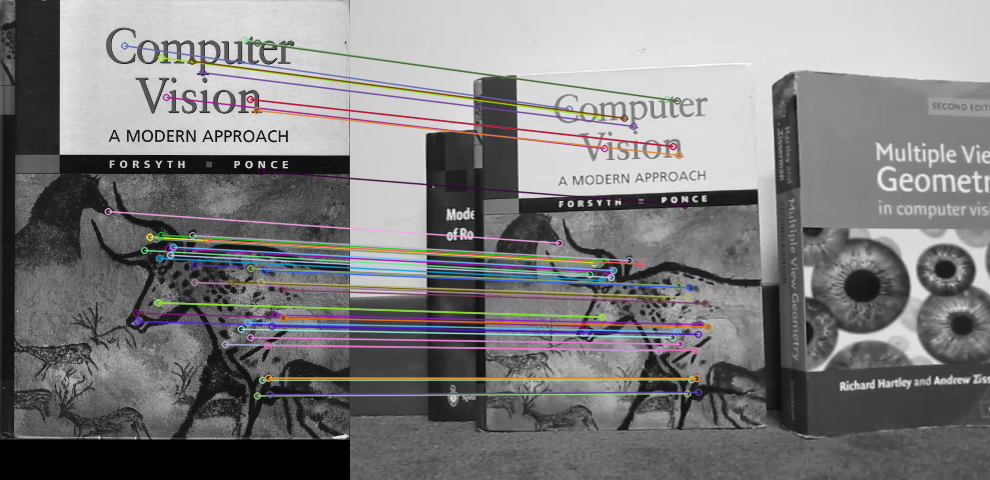

In [12]:
src_pts, dst_pts = get_correspondences(gray_book_cover, gray_book_frames[0], 0.248, True)

### 2. Compute the Homography Parameters

**This method is used to compute the homography matrix:**

**paramerters**

1. **p** the original points.
2. **p_dash** the transformed points.

**return**

The parameters of the homography matrix

**steps**

1. Assert that we have at least four correspondences.
2. Construct the system of equation x' = A * x
3. Compute the svd of matrix A.
4. Select the column of V corrsponding to the smallest singular valuev in A and whose valuse are the parameters of the homography matrix.
5. Return this column after beign reshaped into 3 x 3 matrix.

In [13]:
def compute_homography_parameters(p, p_dash):
  assert len(p) == len(p_dash)
  assert len(p) >= 4

  A = []
  for i in range(len(p)):
    x, y = p[i]
    x_dash, y_dash = p_dash[i]
    A.append(np.array([-x, -y, -1, 0, 0, 0, x*x_dash, y*x_dash, x_dash]))
    A.append(np.array([0, 0, 0, -x, -y, -1, x*y_dash, y*y_dash, y_dash]))

  A = np.array(A)
  U, S, Vt = np.linalg.svd(A, full_matrices=False)

  min_eigenvalue_index = np.argmin(S)
  x = Vt[min_eigenvalue_index, :]

  factor = x[-1]
  x = x * (1/factor)
  x = x.reshape((3, 3))

  return x

Computing the homography using our function and the built-in function in open cv and comparing them

In [14]:
homography_matrix = compute_homography_parameters(src_pts, dst_pts)
homography_matrix_builtin = cv2.findHomography(src_pts, dst_pts)[0]

In [15]:
print(homography_matrix)

[[ 7.73590759e-01  3.54551769e-03  1.19432012e+02]
 [-5.25086579e-02  7.78880843e-01  7.79102820e+01]
 [-9.17335262e-05 -7.32380115e-05  1.00000000e+00]]


In [16]:
print(homography_matrix_builtin)

[[ 7.74868231e-01  3.68078995e-03  1.19317650e+02]
 [-5.18009407e-02  7.79518568e-01  7.77765004e+01]
 [-8.92416965e-05 -7.28527403e-05  1.00000000e+00]]


## 3. Calculate Book Coordinates

Finding the transformation of the book cover corner points using our computed homorgraphy and the one computed using the built-in function and visualizing them

In [17]:
book_cover_corner = np.float32([[0, 0],
                                [0, book_cover.shape[0]],
                                [book_cover.shape[1], 0],
                                [book_cover.shape[1], book_cover.shape[0]]])

transformed_pts_implemented = cv2.perspectiveTransform(book_cover_corner.reshape(-1, 1, 2), homography_matrix)
transformed_pts_builtin = cv2.perspectiveTransform(book_cover_corner.reshape(-1, 1, 2), homography_matrix_builtin)

image_res = book_frames[0].copy()
image_act = book_frames[0].copy()

text_color = (0, 0, 0)

cv2.putText(image_res, "Implemented Homography Matrix", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 2)
cv2.putText(image_act, "Built-in Homography Matrix", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, text_color, 2)

for point in transformed_pts_implemented:
    cv2.circle(image_res, (int(point[0, 0]), int(point[0, 1])), 5, (0, 255, 0), -1)

for point in transformed_pts_builtin:
    cv2.circle(image_act, (int(point[0, 0]), int(point[0, 1])), 5, (0, 255, 0), -1)

concatenated_image = cv2.hconcat([image_res, image_act])

print(f"Implemented transformed point:\n{transformed_pts_implemented}")
print(f"\nBuilt-in transformed point:\n{transformed_pts_builtin}")

Implemented transformed point:
[[[119.432014  77.91028 ]]

 [[125.0208   434.62347 ]]

 [[403.13202   61.507042]]

 [[418.68332  429.89563 ]]]

Built-in transformed point:
[[[119.31765   77.7765  ]]

 [[124.942245 434.69904 ]]

 [[403.11258   61.569263]]

 [[418.6365   429.83875 ]]]


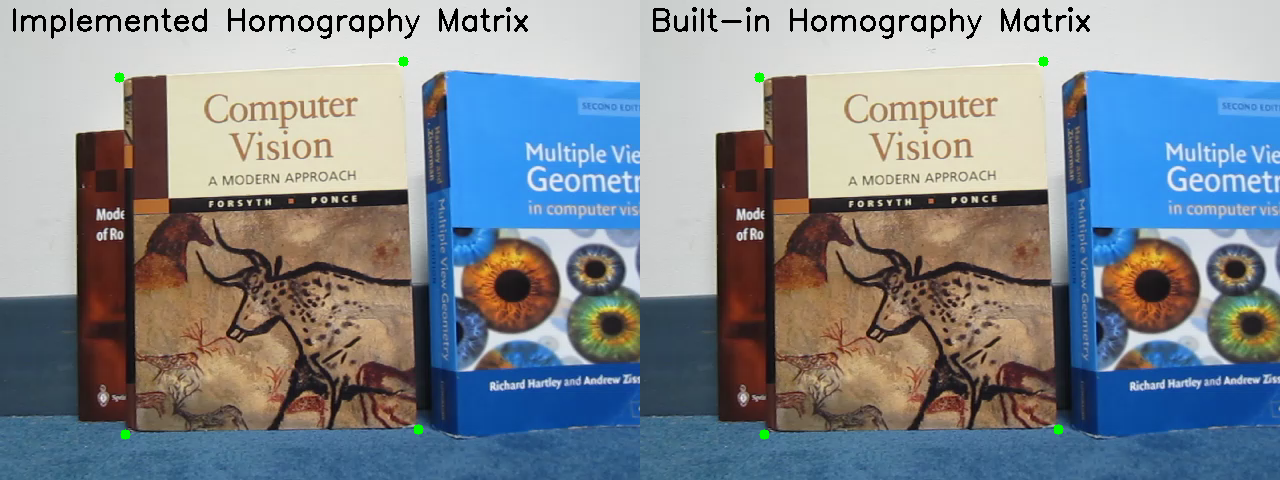

In [18]:
cv2_imshow(concatenated_image)

## 4. Crop AR Video Frames

This function is used to crop a frame from the ceneter keeping the given aspect ratio

In [19]:
def crop_frames(frames, crop_width, crop_height):
  h, w = frames[0].shape[:2]

  aspect_ratio = crop_width / crop_height
  new_width = int(aspect_ratio*h)

  return np.array([frame[:, (w - new_width)//2:(w + new_width)//2] for frame in frames])

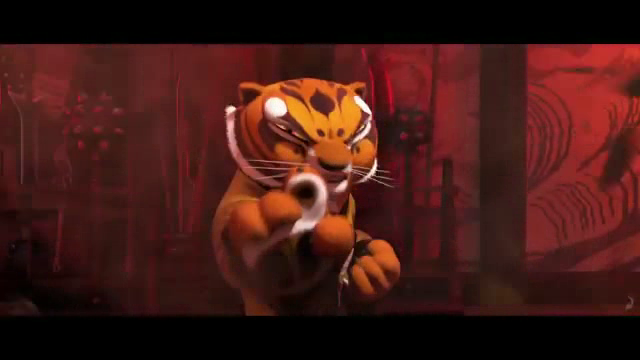

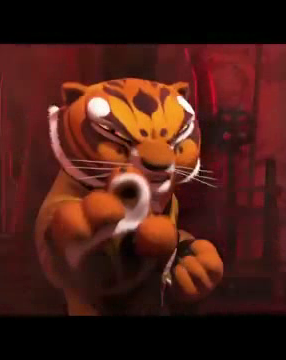

In [20]:
cropped_source_frames = crop_frames(source_frames, book_cover.shape[1], book_cover.shape[0])
cv2_imshow(source_frames[102])
cv2_imshow(cropped_source_frames[102])

## 5. Overlay the First Frame of the Two Videos and Creating AR Application

**This function is used to create the AR Video:**

**parameters**

1. **book_cover** The book cover image that will be used to compute the homography matrix that will transform the trailer video on the book cover video
2. **book_frames** list of book cover video frames
3. **cropped_source_frames** list of the trailer video frames which is cropped to fit the book cover image
4. **video_name** name of the generated video

**return**

A video of the augmented trailer video on the book cover

**steps**

1. At first, we extend the cropped trailer video to have same length of book cover video.
2. Secondly, For each frame in the book cover video, we get the correspondances between the book cover image and video, with distance ratio 0.25 and use them to find the homography matrix.
3. After that, we resize the trailer frame to the book cover size and apply the homography matrix on its pixels to find the new locations of them on the book cover video.
4. Finally, we apply forward warpping and append the new frames that augmented with the trailer in a list which is used to generate the AR video.

In [21]:
def create_ar_video(book_cover, book_frames, cropped_source_frames, video_name):
  frames_to_add = len(book_frames) - len(cropped_source_frames)
  last_frame = cropped_source_frames[-1].copy()
  cropped_source_frames_new = np.concatenate((cropped_source_frames, [last_frame for _ in range(frames_to_add)]))

  gray_book_frames = [cv2.cvtColor(book_frame, cv2.COLOR_BGR2GRAY) for book_frame in book_frames]
  gray_book_cover = cv2.cvtColor(book_cover, cv2.COLOR_BGR2GRAY)

  frames = []
  cover_height, cover_width = book_cover.shape[:2]
  limit_height, limit_width = book_frames[0].shape[:2]

  for i in range(len(book_frames)):
    src_pts, dst_pts = get_correspondences(gray_book_cover, gray_book_frames[i], 0.25)
    homography_matrix = compute_homography_parameters(src_pts, dst_pts)

    resized_image = cv2.resize(cropped_source_frames_new[i], (cover_width, cover_height))

    old_pts = get_image_indices(resized_image)
    transformed_pts = apply_matrix_transformation(homography_matrix, old_pts).astype(int)

    frame = book_frames[i].copy()
    for old_pt, transformed_pt in zip(old_pts, transformed_pts):
      if transformed_pt[0] >= limit_width or transformed_pt[0] < 0 \
          or transformed_pt[1] >= limit_height or transformed_pt[1] < 0:
        continue
      frame[transformed_pt[1], transformed_pt[0]] = resized_image[old_pt[1]][old_pt[0]]

    frames.append(frame)

  return construct_video_from_frames(frames, video_name)

In [22]:
ar_video_name = 'ar_video.mov'
ar_video_path = create_ar_video(book_cover, book_frames, cropped_source_frames, ar_video_name)

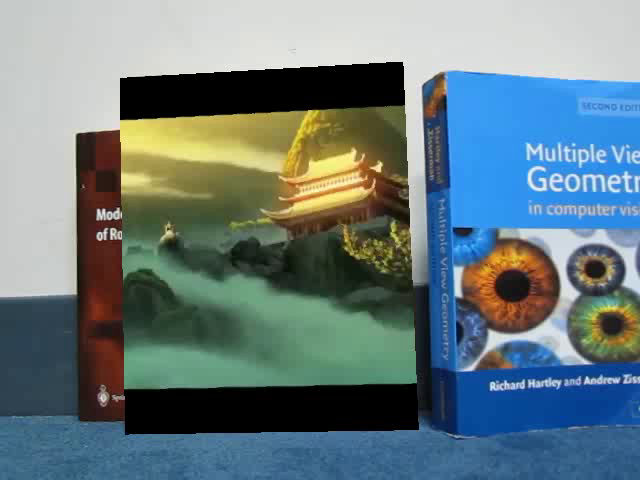

In [23]:
cv2_imshow(extract_frames(ar_video_path)[0])

In [24]:
# run this cell to download the AR video directly
files.download(ar_video_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>